## Imports

In [1]:
import os
import pandas as pd
import csv
import json
import glob
import logging
import numpy as np

## Handling metadata

In [ ]:
def get_qualisys_metadata(filename: str) -> dict:
    """
    Reads qualisys export file in .tsv format along with (custom) json files, parses metadata.
    Exported file has to include tsv-header (qualisys export setting).

    Args:
        filename: path to the qualisys export file in .tsv format

    Returns:
        qualisys_metadata: metadata in dict format
    """

    qualisys_metadata = {}
    with open(filename) as f:
        # read file with csv reader. no need for pandas for just a few lines
        reader = csv.reader(f, delimiter="\t", quotechar='"')

        for ind, row in enumerate(reader):
            # only the first 9 rows of the whole file contain the tsv header metadata
            if ind <= 8:
                if ind < 6:
                    qualisys_metadata[row[0]] = float(row[1])
                # this row has 2 pieces of info; timestamp of the recording from qualisys (this cant be used for sync), timestamp from the start of host system
                elif ind == 7:
                    qualisys_metadata[row[0] + "_QUALISYS"] = row[1]
                    qualisys_metadata[row[0] + "_FROM_SYSTEM_START"] = row[2]
                else:
                    qualisys_metadata[row[0]] = row[1]
            if ind == 9:
                qualisys_metadata['marker_names'] = row[1:]

    return qualisys_metadata


def read_improper_json_file(filename: str) -> dict:
    """
    Reads a json file that has been improperly formatted (e.g. single quotes instead of double quotes).
    Args:
        filename (str): path to the json file

    Returns:
        json_data (dict): data with formatting corrected.
    """
    path = os.path.join(".", filename)
    if os.path.isfile(path):
        with open(path, "r") as f:
            content = f.read()
            json_data = json.loads(content.replace("'", '"'))

    return json_data


def get_json_metadata() -> dict:
    """
    Reads two json metadata files (w predefined names and path) from the start and stop of a recording session.
    Corrects the formatting (' to ") and checks for consistency between the two files.
    Puts the unified metadata into a single dictionary.

    Args:
        None

    Returns:
        unified_json_data (dict): a dictionary containing the unified metadata from both json files.
    """

    # read in both metadata json files
    data_start = read_improper_json_file("data_start.json")
    data_stop = read_improper_json_file("data_stop.json")

    unified_json_data = {}

    # check if both have the same field names (keys)
    if data_start.keys() == data_stop.keys():

        # check if the uuid is the same in both
        if data_start["uuid"] == data_stop["uuid"]:
            unified_json_data["uuid"] = data_start["uuid"]

        else:
            msg = f'uuid different for {data_start["filename"]}'
            logging.error(msg)

        # check if the filename is the same in both

        if data_start["filename"] == data_stop["filename"]:
            unified_json_data["filename"] = data_start["filename"]

        else:

            msg = f'filename different for {data_start["filename"]}'
            logging.error(msg)

        # check if the timestamps are different (they should be)
        if data_start["timestamp"] != data_stop["timestamp"]:
            unified_json_data["timestamp_start"] = data_start["timestamp"]
            unified_json_data["timestamp_stop"] = data_stop["timestamp"]

        else:
            msg = f'timestamps are identical for  {data_start["filename"]}'
            logging.error(msg)

        # check if the timestamps for qualisys ARE different (they should be)
        if data_start["timestamp_qualisys"] != data_stop["timestamp_qualisys"]:
            unified_json_data["timestamp_qualisys_start"] = data_start["timestamp_qualisys"]
            unified_json_data["timestamp_qualisys_stop"] = data_stop["timestamp_qualisys"]

        else:
            msg = f'timestamp_qualisys are identical for {data_start["filename"]}'
            logging.error(msg)
    else:
        msg = f'keys of json files are different: {set(data_start.keys()).difference(data_stop.keys())} for {data_start["filename"]}'
        logging.error(msg)

    return unified_json_data


# get_qualisys_metadata("./tsv_exp_header_colhead_time.tsv")

In [ ]:
# TODO: add logging to file

# read in and process json metadata files
json_metadata = get_json_metadata()

# read in and process metadata (header) from qualisys export file
qualisys_metadata = get_qualisys_metadata("./tsv_exp_header_colhead_time.tsv")

# combine the two dictionaries 
# note: this will overwrite data with the same keys, they have to be unique
metadata = qualisys_metadata | json_metadata

# write result to a json file
with open("./all_metadata.json", "w") as f:
    json.dump(metadata, f)

## Handling qualisys export data

#### Process local files

In [14]:
for g in glob.glob("./gapfilled_exports/*.tsv"):
    input_folder = "./gapfilled_exports"
    input_filename = g.split("\\")[1]
    f = os.path.join(input_folder, input_filename)

    # read first 10 rows to get number of markers, frames, marker names...
    metadata = get_qualisys_metadata(f)

    # Read the TSV file, skipping the first 10 rows (only metadata)
    df = pd.read_csv(f, sep="\t", header=None, skiprows=11, dtype=None)

    # Convert the DataFrame to a numpy array, transpose it (so it is (markers x dims) x frames)
    data = df.to_numpy().T

    # discrard the first two rows (frame number and relative timestamp)
    data = data[2:, :]

    # reshape the data to    markers x dims x frames
    data = data.reshape(int(metadata["NO_OF_MARKERS"]), 4, int(metadata["NO_OF_FRAMES"]))

    # iterate over all keypoints
    for kpt_idx, keypoint in enumerate(data):
        # get the type of measurement for all frames of a given keypoint
        measurement_types = keypoint[3, :]
        # iterate over all dims (x,y,z,type) of a keypoint
        for dim_idx, dim in enumerate(keypoint):

            # replace coordinates with nan when it is gap-filled by qualisys, convert coords to float
            if dim_idx <= 2:
                data[kpt_idx, dim_idx, :] = np.where(
                    measurement_types == "Measured", dim, "Nan"
                ).astype(float)

            # leave type as str ('Measured' or 'Gap-filled')
            elif dim_idx == 3:
                pass
    # remove dim 3 (type of measurement)
    data = data[:, :3, :].astype(float)
    print(f"data shape: {data.shape}")

    output_folder = './preprocessed_data'
    out_filename = os.path.join(output_folder, input_filename.replace('.tsv', '.npz'))
    with open(out_filename, 'w') as f:
        np.savez(out_filename, pose_data=data, kpt_labels=metadata['marker_names'])

data shape: (23, 3, 6446)
data shape: (23, 3, 6443)
data shape: (23, 3, 6177)
data shape: (23, 3, 6348)
data shape: (23, 3, 6340)
data shape: (23, 3, 6316)
data shape: (23, 3, 6436)
data shape: (23, 3, 6347)
data shape: (23, 3, 6395)
data shape: (23, 3, 6336)
data shape: (23, 3, 6444)


#### basic code (same as above)

In [ ]:
input_folder = "./gapfilled_exports"
input_filename = "A2A6841F-E163-433C-BEF4-55BD9C15437A_mate_walking.tsv"
f = os.path.join(input_folder, input_filename)

# read first 10 rows to get number of markers, frames, marker names...
metadata = get_qualisys_metadata(f)

# Read the TSV file, skipping the first 10 rows (only metadata)
df = pd.read_csv(f, sep="\t", header=None, skiprows=11, dtype=None)

# Convert the DataFrame to a numpy array, transpose it (so it is (markers x dims) x frames)
data = df.to_numpy().T

# discrard the first two rows (frame number and relative timestamp)
data = data[2:, :]

# reshape the data to    markers x dims x frames
data = data.reshape(int(metadata["NO_OF_MARKERS"]), 4, int(metadata["NO_OF_FRAMES"]))

data.shape

(23, 4, 6336)

#### deleting gap-filled entries (same as above)

In [ ]:
# iterate over all keypoints
for kpt_idx, keypoint in enumerate(data):
    # get the type of measurement for all frames of a given keypoint
    measurement_types = keypoint[3, :]
    # iterate over all dims (x,y,z,type) of a keypoint
    for dim_idx, dim in enumerate(keypoint):

        # replace coordinates with nan when it is gap-filled by qualisys, convert coords to float
        if dim_idx <= 2:
            data[kpt_idx, dim_idx, :] = np.where(
                measurement_types == "Measured", dim, "Nan"
            ).astype(float)

        # leave type as str ('Measured' or 'Gap-filled')
        elif dim_idx == 3:
            pass
# remove dim 3 (type of measurement)
data = data[:, :3, :].astype(float)
print(f"data shape: {data.shape}")

data shape: (23, 3, 6336)


In [ ]:
output_folder = './preprocessed_data'
out_filename = os.path.join(output_folder, input_filename.replace('.tsv', '.npz'))
with open(out_filename, 'w') as f:
    np.savez(out_filename, pose_data=data, kpt_labels=metadata['marker_names'])

## Visualization

In [1]:
%matplotlib ipympl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
import numpy as np

In [2]:
# f = './filtered_data.npz'
# f = './processed_data.npz'
f = './raw_data.npz'
loaded_data = np.load(f, allow_pickle=True)
data = loaded_data['pose_data']
print(f'og shape: {data.shape}')
for i,k in enumerate(loaded_data['kpt_labels']):
    print(i,k)

og shape: (23, 3, 6336)
0 right_big_toe
1 right_ankle
2 right_heel
3 left_big_toe
4 left_ankle
5 left_heel
6 right_knee
7 left_knee
8 right_hip_front
9 left_hip_front
10 right_hip_back
11 left_hip_back
12 right_shoulder
13 left_shoulder
14 right_ear
15 left_ear
16 nose
17 right_elbow
18 left_elbow
19 right_wrist
20 left_wrist
21 right_index_finger
22 left_index_finger


In [10]:
data = data.astype(float)
data.shape

(23, 3, 6336)

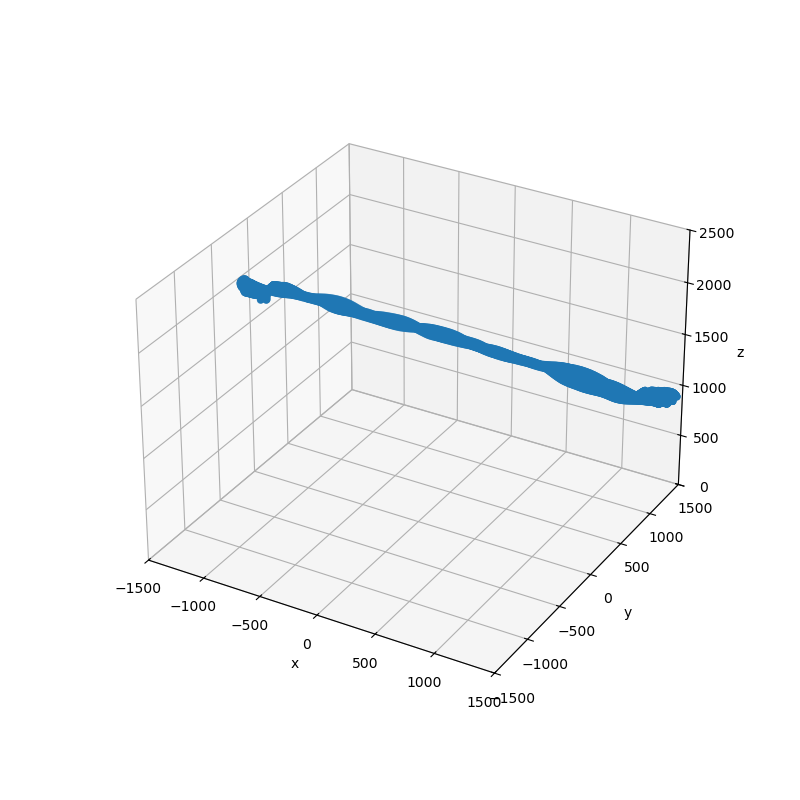

In [4]:
kpt_idx = 16
x = data[kpt_idx,0,:]
y = data[kpt_idx,1,:]
z = data[kpt_idx,2,:]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")


ax.set_aspect("auto")
ax.set_xlim(-1500, 1500)
ax.set_ylim(-1500, 1500)
ax.set_zlim(0, 2500)

ax.scatter(x, y, z)
plt.show()